**Predict fuel efficiency:**

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [1]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, seaborn as sns

#Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Accelarator', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelarator,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
%%time
def description(df):
    """
    Return basic statistics.
    """
    summary = pd.DataFrame(df.dtypes, columns=['dtypes']).reset_index()
    summary = summary.rename(columns={'index':'name'})
    summary['Missing'] = df.isnull().sum().values
    #summary['sample'] = summary.name.apply(lambda x: data[x].sample(frac=1.).values.tolist()[0])
    summary['nunique'] = df.nunique().values
    summary['unique'] = df.apply(lambda x: list(x.unique()), axis=0).reset_index()[0]
    return summary

description(dataset)

CPU times: user 11.7 ms, sys: 4.83 ms, total: 16.5 ms
Wall time: 16.8 ms


,name,dtypes,Missing,nunique,unique
0,MPG,float64,0,129,"[18.0, 15.0, 16.0, 17.0, 14.0, 24.0, 22.0, 21...."
1,Cylinders,int64,0,5,"[8, 4, 6, 3, 5]"
2,Displacement,float64,0,82,"[307.0, 350.0, 318.0, 304.0, 302.0, 429.0, 454..."
3,Horsepower,float64,6,93,"[130.0, 165.0, 150.0, 140.0, 198.0, 220.0, 215..."
4,Weight,float64,0,351,"[3504.0, 3693.0, 3436.0, 3433.0, 3449.0, 4341...."
5,Accelarator,float64,0,95,"[12.0, 11.5, 11.0, 10.5, 10.0, 9.0, 8.5, 8.0, ..."
6,Model Year,int64,0,13,"[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8..."
7,Origin,int64,0,3,"[1, 3, 2]"


In [5]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Accelarator,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


Looking at the overall statistics, we can note that each feature covers a very different range

In [6]:
#dataset.Horsepower.value_counts().idxmax(), np.median(dataset.Horsepower), dataset.Horsepower.mode()
dataset['Horsepower'] = dataset['Horsepower'].fillna(dataset.Horsepower.value_counts().idxmax())
description(dataset)

,name,dtypes,Missing,nunique,unique
0,MPG,float64,0,129,"[18.0, 15.0, 16.0, 17.0, 14.0, 24.0, 22.0, 21...."
1,Cylinders,int64,0,5,"[8, 4, 6, 3, 5]"
2,Displacement,float64,0,82,"[307.0, 350.0, 318.0, 304.0, 302.0, 429.0, 454..."
3,Horsepower,float64,0,93,"[130.0, 165.0, 150.0, 140.0, 198.0, 220.0, 215..."
4,Weight,float64,0,351,"[3504.0, 3693.0, 3436.0, 3433.0, 3449.0, 4341...."
5,Accelarator,float64,0,95,"[12.0, 11.5, 11.0, 10.5, 10.0, 9.0, 8.5, 8.0, ..."
6,Model Year,int64,0,13,"[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8..."
7,Origin,int64,0,3,"[1, 3, 2]"


In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelarator,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Split the data into train and test: There are more sophisticated ways to perform this as **test_train_split** from sklearn

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Let's inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

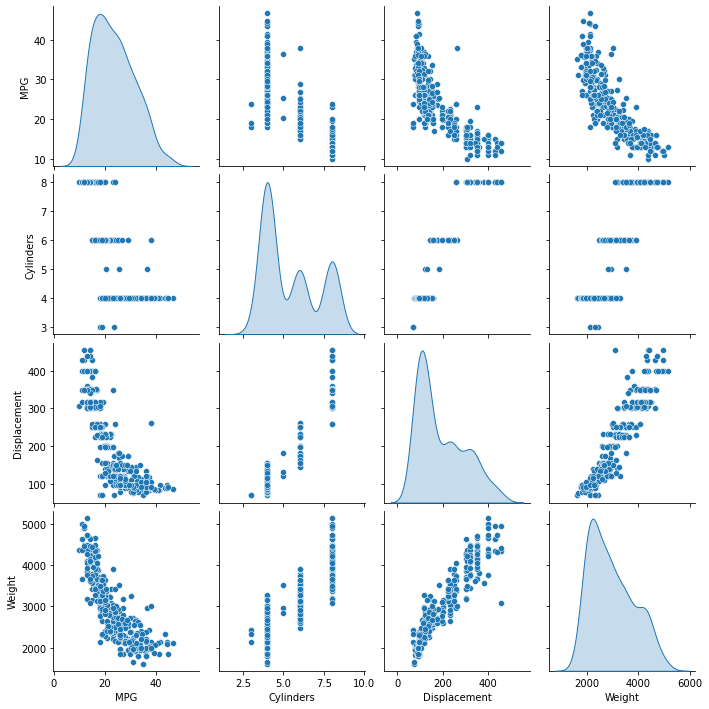

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

**Normalization:**

In the table of statistics it's easy to see how different the ranges of each feature are.

In [11]:
train_dataset.describe().transpose()[['mean',  'std']]

,mean,std
MPG,23.590566,7.913617
Cylinders,5.427673,1.682941
Displacement,193.061321,103.812742
Horsepower,104.789308,38.792942
Weight,2963.823899,844.749805
Accelarator,15.595912,2.796282
Model Year,75.946541,3.705266
Europe,0.163522,0.370424
Japan,0.194969,0.396801
USA,0.641509,0.480313


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.  Although a model *might* converge without feature normalization, normalization makes training much more stable.

The **preprocessing.Normalization layer** is a clean and simple way to build that preprocessing into your model.

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features)) #This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

[   5.428  193.061  104.789 2963.824   15.596   75.947    0.164    0.195
    0.642]


When the layer is called it returns the input data, with each feature independently normalized: 

In [13]:
first = np.array(train_features[:1])
print(first)
print(normalizer(first).numpy())

[[   8.  351.  153. 4129.   13.   72.    0.    0.    1.]]
[[ 1.531  1.524  1.245  1.381 -0.93  -1.067 -0.442 -0.492  0.748]]


**Linear regression:** Before building a DNN model, Let's start with a linear regression with one variable (Horsepower).

In this case use a **keras.Sequential model**. This model represents a sequence of steps. In this case there are two steps:

 * Normalize the input horsepower.
 * Apply a linear transformation $(y = mx + b) $ to produce 1 output using layers.Dense
 
*This model will predict MPG from Horsepower.*

In [14]:
horsepower_normalizer = preprocessing.Normalization()

horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer.adapt(horsepower)

In [15]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer,
                                       layers.Dense(units=1)])

horsepower_model.compile(optimizer=keras.optimizers.Adam(lr=0.1), 
                        loss='mean_absolute_error')
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


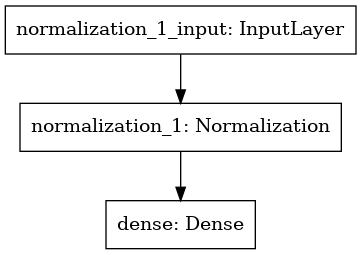

In [16]:
tf.keras.utils.plot_model(horsepower_model)

In [17]:
horsepower_model.predict(horsepower[:10])

array([[-0.398],
       [ 0.246],
       [-0.291],
       [ 0.147],
       [ 0.04 ],
       [ 0.295],
       [ 0.328],
       [ 0.122],
       [-0.373],
       [-0.043]], dtype=float32)

In [18]:
history = horsepower_model.fit(train_features['Horsepower'],
                               train_labels,
                              epochs=100,
                              verbose=0, #Suppress logging
                              validation_split=0.2)

In [19]:
#Let's visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,4.088156,4.079836,95
96,4.087001,4.082942,96
97,4.088006,4.086176,97
98,4.092116,4.072275,98
99,4.087618,4.079355,99


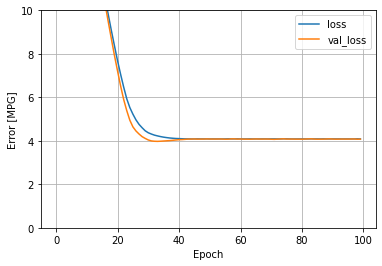

In [20]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

In [21]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels, verbose=0)

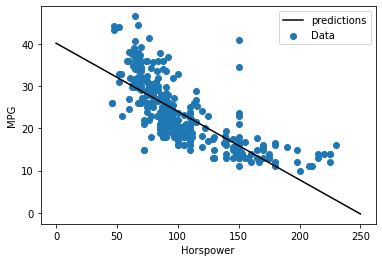

In [22]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='predictions')
    plt.xlabel('Horspower')
    plt.ylabel('MPG')
    plt.legend()
    
plot_horsepower(x, y)

Now let's try **Multiple inputs**

In [23]:
linear_model = tf.keras.Sequential([normalizer,
                                   layers.Dense(units=1)])
linear_model.compile(optimizer=tf.optimizers.Adam(lr=0.1),
                    loss = 'mean_absolute_error')

In [24]:
linear_model.predict(train_features[:10])

array([[ 0.49 ],
       [-0.625],
       [-0.918],
       [-0.673],
       [-0.621],
       [-1.553],
       [-0.552],
       [-1.053],
       [ 1.762],
       [ 1.169]], dtype=float32)

When you call the model it's **weight matrices** will be built. Now you can see that the **kernel** (the $m $ in $y = mx + b $) has a shape of **(9,1)**

In [25]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.437],
       [ 0.489],
       [ 0.715],
       [-0.652],
       [-0.753],
       [ 0.246],
       [ 0.666],
       [ 0.034],
       [ 0.399]], dtype=float32)>

In [26]:
history = linear_model.fit(train_features, 
                           train_labels,
                           epochs=100,
                          verbose=0, 
                          validation_split=0.2)

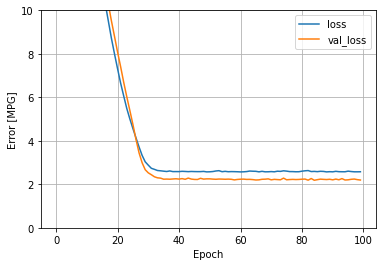

In [27]:
plot_loss(history)

In [28]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

**A DNN regression:**
The previous section implemented linear models for single and multiple inputs.

This section implements **single-input and multiple-input DNN models**. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

 * The normalization layer.
 * Two hidden, nonlinear, Dense layers using the relu nonlinearity.
 * A linear single-output layer.
 
Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.

In [29]:
def build_and_compile_model(norm):
    model = keras.Sequential([norm,
                             layers.Dense(64, activation='relu'),
                             layers.Dense(64, activation='relu'),
                             layers.Dense(1)])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='mean_absolute_error')
    return model

In [30]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


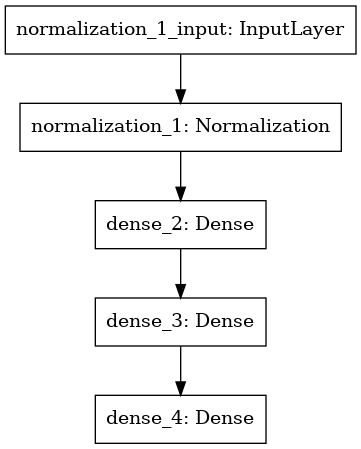

In [31]:
tf.keras.utils.plot_model(dnn_horsepower_model)

In [32]:
history = dnn_horsepower_model.fit(train_features['Horsepower'],
                        train_labels,
                        epochs=100,
                        validation_split=0.2,
                        verbose=0)

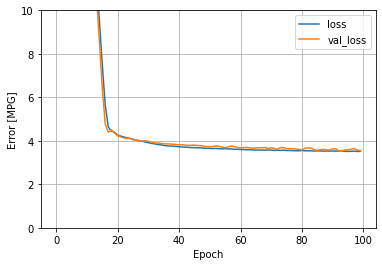

In [33]:
plot_loss(history)

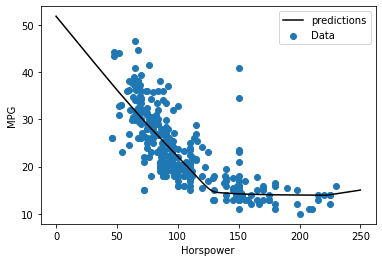

In [35]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)

We can see that this model takes advantage of the nonlinearity provided by the hidden layers.

In [36]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'],
                                                                     test_labels,
                                                                      verbose=0)

**Full model**

In [37]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


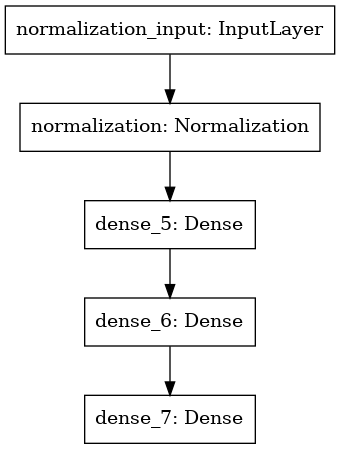

In [38]:
tf.keras.utils.plot_model(dnn_model)

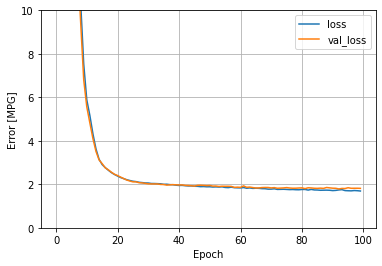

In [39]:
history = dnn_model.fit(train_features,
                        train_labels,
                        epochs=100,
                        validation_split=0.2,
                        verbose=0)
plot_loss(history)

In [40]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

**Performance**

In [41]:
pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

,Mean Absolute Error [MPG]
horsepower_model,3.333832
linear_model,2.374160
dnn_horsepower_model,3.211400
dnn_model,1.890055


**Predictions**

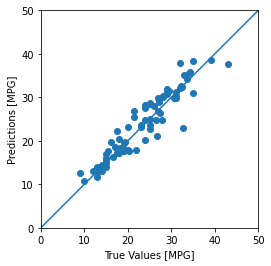

In [45]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like the model predicts reasonably well

Now take a look at **the error distribution**:

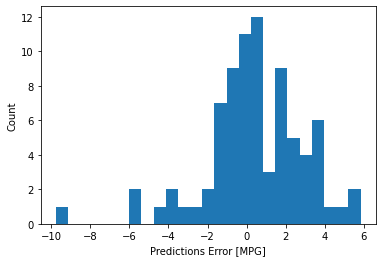

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Predictions Error [MPG]')
_ = plt.ylabel('Count')

The error seems **normaly distributed**. Let's save it for later use.

In [47]:
dnn_model.save('dnn_model')

# reloaded = tf.keras.models.load_model('dnn_model')

# test_results['reloaded'] = reloaded.evaluate(test_features,
#                                             test_labels,
#                                             verbose=0)

# pd.DataFrame(test_results, index=['Mean Absolute Error [MPG]']).T

# If you reload the model, it gives identical output

INFO:tensorflow:Assets written to: dnn_model/assets


**Conclusion:**
    
This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

 * [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. **Mean Absolute Error is less sensitive to outliers**. Different loss functions are used for classification problems.

 * Similarly, evaluation metrics used for regression differ from classification.
 * When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
